<a href="https://colab.research.google.com/github/pdoren/analisis-estadistico-con-Python-G105/blob/main/Desaf%C3%ADo_Tabaquismo_y_gestaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafío - Tabaquismo y gestación

**Nombre**: Pablo Saavedra <br />
**Curso**: Análisis estadístico con Python (G105)


---

## Carga de librerías y definición de funciones de apoyo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats

pd.options.display.float_format = "{:,.2f}".format   # Visualizar 2 decimales

def get_outliers(_df: pd.DataFrame, _cols: list,
                 _k: float=1.5):
  ret = None
  for col in _cols:
    q1, q3 = _df[col].quantile([.25, .75])
    iqr = q3 - q1
    low, high = q1 - _k * iqr, q3 + _k * iqr
    mask_out = (_df[col] < low) | (_df[col] > high)
    if mask_out.any():
      if ret is None:
        ret = mask_out
      else:
        ret = ret | mask_out
  return ret

## 1. Exploración de Datos

Realiza una exploración de los datos, considerando sus tipos y los descriptivos correspondientes.

---

Primero se cargan los datos:

In [2]:
df = pd.read_csv('/content/drive/MyDrive/baby.csv')
df.drop('Unnamed: 0', axis=1, inplace=True) # Se elimina columna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174 entries, 0 to 1173
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Birth.Weight               1174 non-null   int64
 1   Gestational.Days           1174 non-null   int64
 2   Maternal.Age               1174 non-null   int64
 3   Maternal.Height            1174 non-null   int64
 4   Maternal.Pregnancy.Weight  1174 non-null   int64
 5   Maternal.Smoker            1174 non-null   bool 
dtypes: bool(1), int64(5)
memory usage: 47.1 KB


Se revisan las estadísticas generales:

In [3]:
df.describe()

,Birth.Weight,Gestational.Days,Maternal.Age,Maternal.Height,Maternal.Pregnancy.Weight
count,"1,174.00","1,174.00","1,174.00","1,174.00","1,174.00"
mean,119.46,279.10,27.23,64.05,128.48
std,18.33,16.01,5.82,2.53,20.73
min,55.00,148.00,15.00,53.00,87.00
25%,108.00,272.00,23.00,62.00,114.25
50%,120.00,280.00,26.00,64.00,125.00
75%,131.00,288.00,31.00,66.00,139.00
max,176.00,353.00,45.00,72.00,250.00


En primer lugar no se observan datos nulos.

En segundo lugar, por los datos estadísticos obtenidos se observa que los promedios de peso y altura de una mujer y un bebe no están en unidades del Sistema Internacinoal (SI), es decir, en Kg y metros. Los datos están en unidades de Estados Unidos:

- **Birth.Weight** está en Onzas
- **Maternal.Pregnancy.Weight** en Libras
- **Maternal.Height** en Pulgadas

A continuación, se convertiran estos datos a unidades del Sistema Internacional de Unidades (SI):

In [4]:
df['Birth.Weight'] = df['Birth.Weight'] * 0.0283495 # Kilos
df['Maternal.Pregnancy.Weight'] = df['Maternal.Pregnancy.Weight'] * 0.453592 # Kilos
df['Maternal.Height'] = df['Maternal.Height'] * 2.54 / 100.0 # metros
df.describe()

,Birth.Weight,Gestational.Days,Maternal.Age,Maternal.Height,Maternal.Pregnancy.Weight
count,"1,174.00","1,174.00","1,174.00","1,174.00","1,174.00"
mean,3.39,279.10,27.23,1.63,58.28
std,0.52,16.01,5.82,0.06,9.40
min,1.56,148.00,15.00,1.35,39.46
25%,3.06,272.00,23.00,1.57,51.82
50%,3.40,280.00,26.00,1.63,56.70
75%,3.71,288.00,31.00,1.68,63.05
max,4.99,353.00,45.00,1.83,113.40


De estos datos ontenidos se puede advertir que existen varios outliers como se ve en el gráfico de caja de abajo.

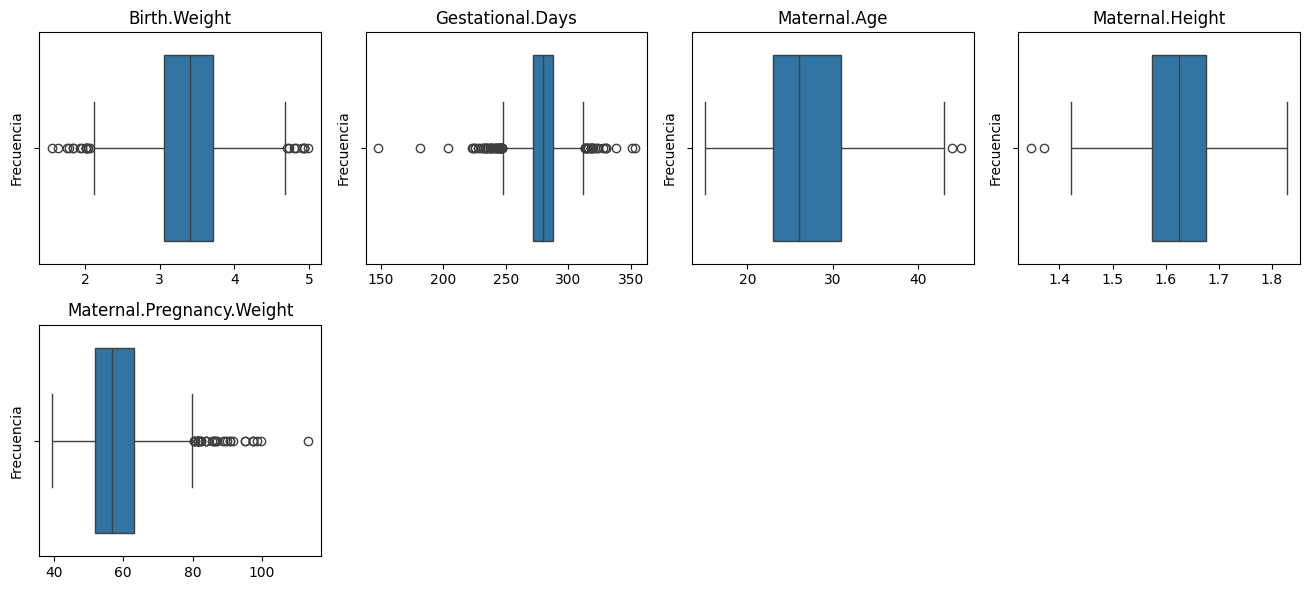

In [5]:
cols = df.select_dtypes(include="number").columns # seleccionar datos númericos

# Ajustes para plot
bins      = 'fd'     # nº de barras por histograma, Freedman-Diaconis
add_kde   = True     # curva KDE encima del histograma
wrap_cols = 4        # nº de subgráficas por fila
fig_h     = 3        # alto (pulgadas) de cada faceta
fig_aspect= 1.1      # ancho ≈ alto*aspect

# Rejilla
n_plots   = len(cols)
n_rows    = math.ceil(n_plots / wrap_cols)
fig_w     = wrap_cols * fig_h * fig_aspect

fig, axes = plt.subplots(n_rows, wrap_cols,
                         figsize=(fig_w, n_rows * fig_h),
                         sharex=False, sharey=False)

axes = axes.ravel()

# Plot Boxplot
for i, col in enumerate(cols):
    ax = axes[i]
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(col)
    ax.set_xlabel("")     # deja limpio o personaliza
    ax.set_ylabel("Frecuencia")

# Eliminar Celdas Vacias
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



Vamos a proceder a eliminar los outliers y volver a obetener las estadísticas y el gráfico de caja para validar el procedimiento.

In [6]:
while True:
  outliers  = get_outliers(df, cols)
  if outliers is None:
    break
  df = df[~outliers]
df.describe()

,Birth.Weight,Gestational.Days,Maternal.Age,Maternal.Height,Maternal.Pregnancy.Weight
count,989.00,989.00,989.00,989.00,989.00
mean,3.41,280.31,26.74,1.62,56.72
std,0.45,10.90,5.31,0.06,7.18
min,2.27,251.00,15.00,1.42,39.46
25%,3.12,273.00,23.00,1.57,51.26
50%,3.40,280.00,26.00,1.63,56.70
75%,3.69,288.00,30.00,1.68,61.23
max,4.54,309.00,40.00,1.83,74.84


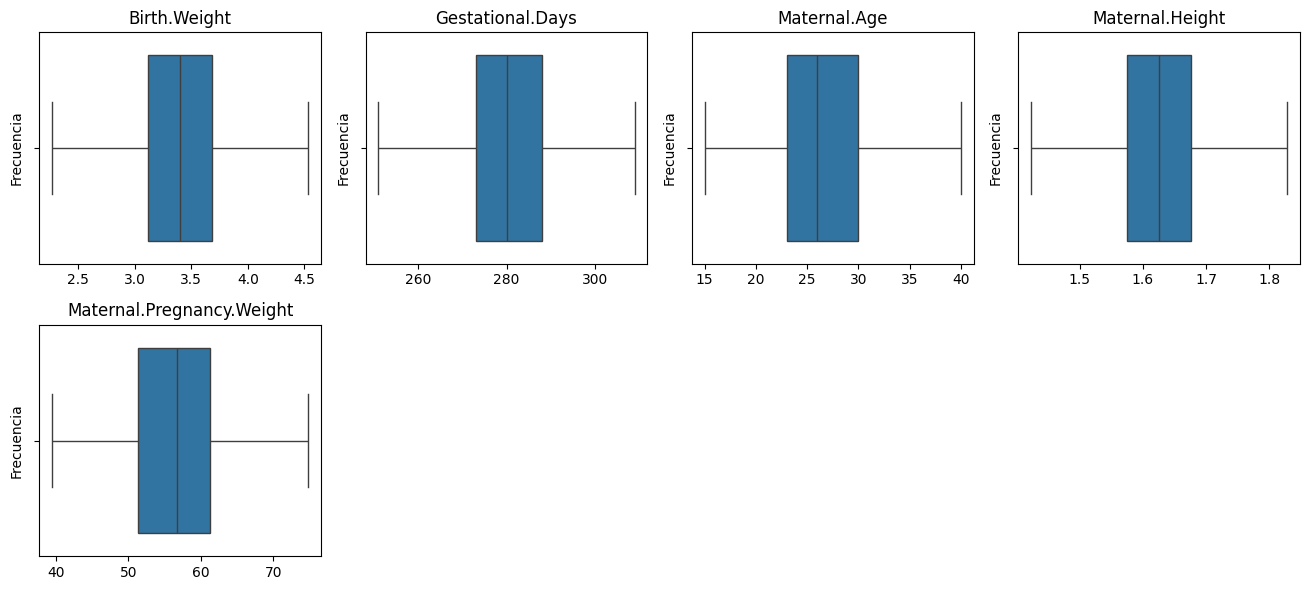

In [7]:
fig, axes = plt.subplots(n_rows, wrap_cols,
                         figsize=(fig_w, n_rows * fig_h),
                         sharex=False, sharey=False)

axes = axes.ravel()

# Plot Boxplot
for i, col in enumerate(cols):
    ax = axes[i]
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(col)
    ax.set_xlabel("")     # deja limpio o personaliza
    ax.set_ylabel("Frecuencia")

# Eliminar Celdas Vacias
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

No existe correlación entre las diferentes variables:

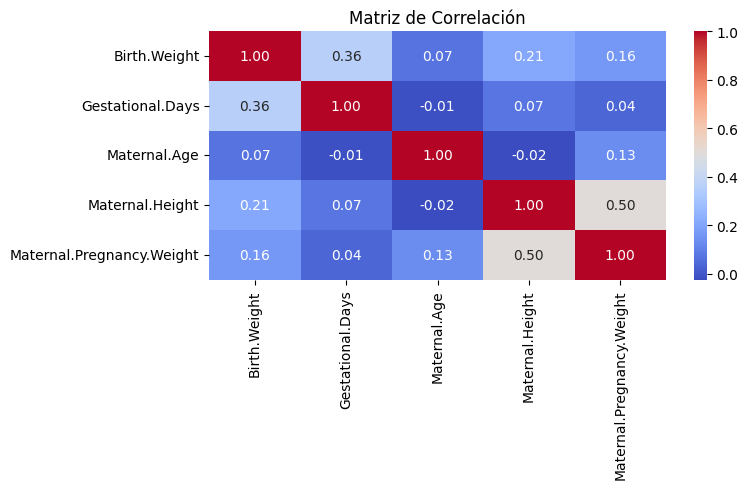

In [8]:
matriz_correlacion = df.select_dtypes(include="number").corr()

plt.figure(figsize=(8, 5))
sns.heatmap(matriz_correlacion, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.tight_layout()
plt.show()

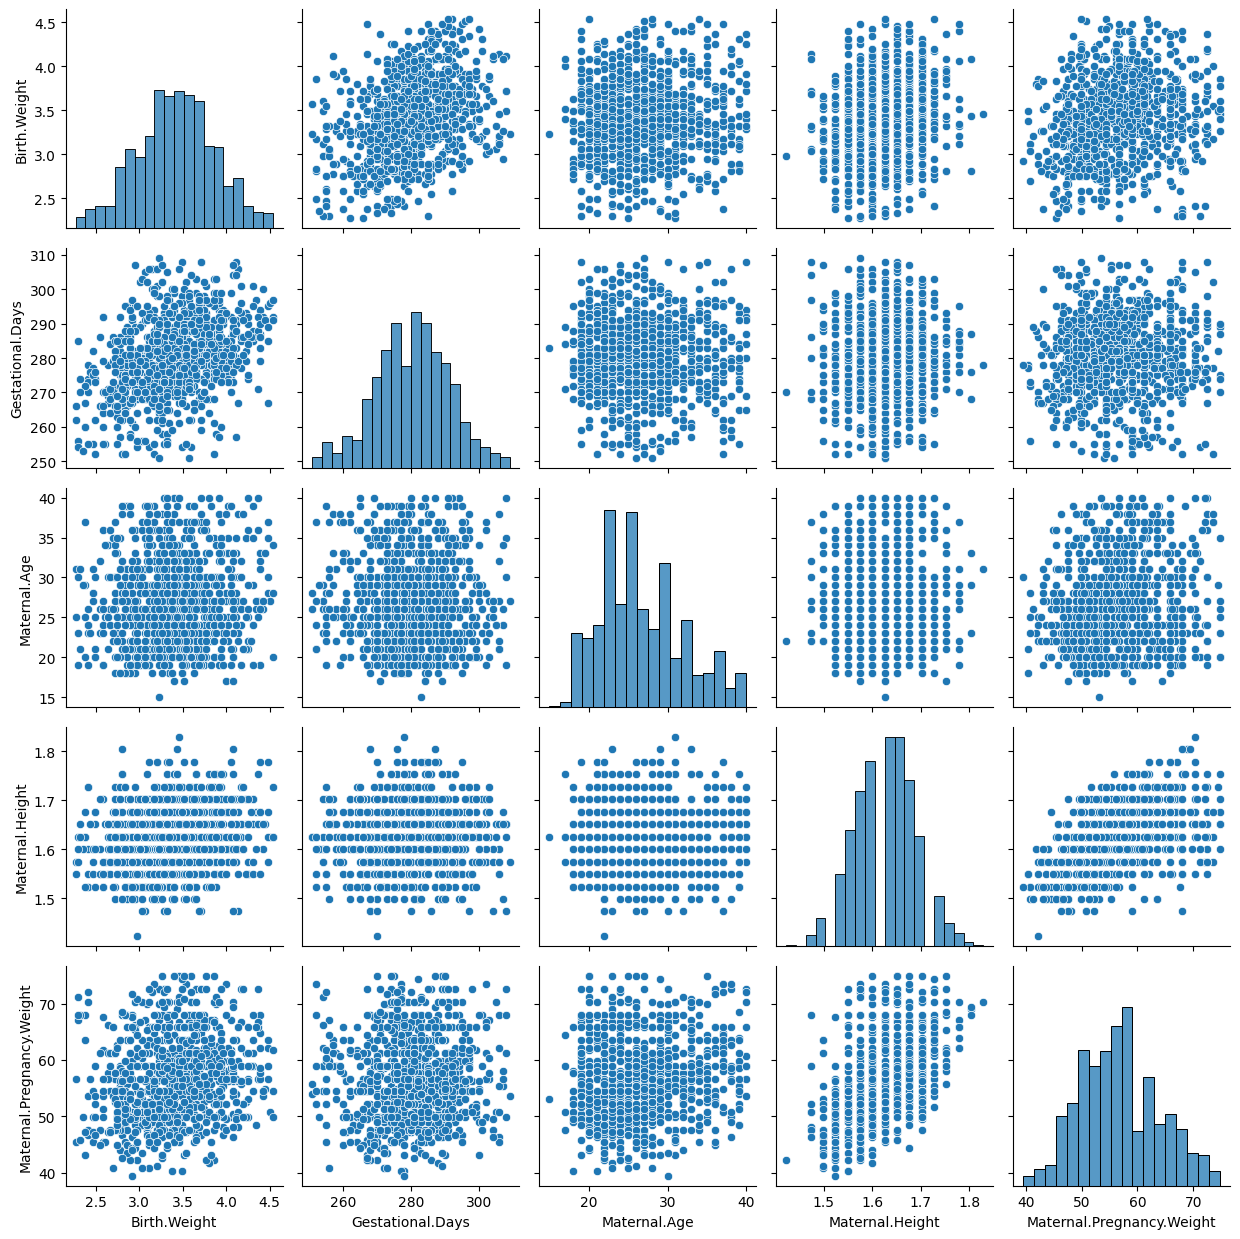

In [9]:
sns.pairplot(df.select_dtypes(include="number"))
plt.tight_layout()
plt.show()

### Resumen procesamniento de datos

1. Se eliminó una columna que no era parte del análisis
2. Se validó que no existieran valores nulos
3. Se convirtieron los datos de pesos y altura al sistema de unidades SI
4. Se eliminaron todos los outliers
5. No existe correlación entre las variables

## 2. Pesos Bebes
Considera los pesos de los bebés. ¿Se puede decir que siguen una distribución normal? Justifica tu respuesta creando los gráficos y modelos necesarios.

---

Primero para revisar si los datos distribuyen como una normal se gráfica el histograma:

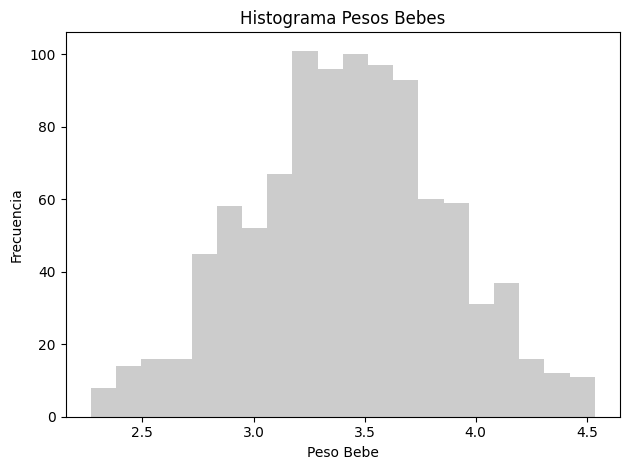

In [10]:
data = df['Birth.Weight']

sns.histplot(data,
             bins='fd',
             color="grey",
             alpha=.4,
             edgecolor="none")

plt.xlabel("Peso Bebe")
plt.ylabel("Frecuencia")
plt.title(r"Histograma Pesos Bebes")
plt.tight_layout()
plt.show()

Los datos distribuyen de una forma similar a una normal. Para comprobar con la función de distribución se calculará la media y la distribución de los datos y serviran de parámetros de la distribución. La ecuación de la distribución es:



$$ f(x) = \frac{1}{σ \cdot \sqrt{2π}} \cdot e^\frac{-(x - μ)^2}{2σ^2} $$

Donde: <br />
$x$: es el valor de la variable aleatoria<br />
$μ$: es la media (promedio) de la distribución<br />
$σ$: es la desviación estándar<br />
$π$: es la constante matemática pi<br />
$e$: es el número de Euler<br />

Se procede a calcular los parámetros y obtener los puntos de la curva de la distribución normal:

In [11]:
def normal(x, _mu, _sigma):
  # Función para calcular la normal
  return (1 / (_sigma * np.sqrt(2 * np.pi))) * np.exp(-((x - _mu)**2) / (2 * _sigma**2))

mu, sigma = data.mean(), data.std(ddof=0)       # media y desviación
x = np.linspace(data.min(), data.max(), 200)    # eje x para la curva
y = normal(x, mu, sigma)                        # densidad normal (PDF)


Se gráfican el histograma y la distribución juntas para comparar:

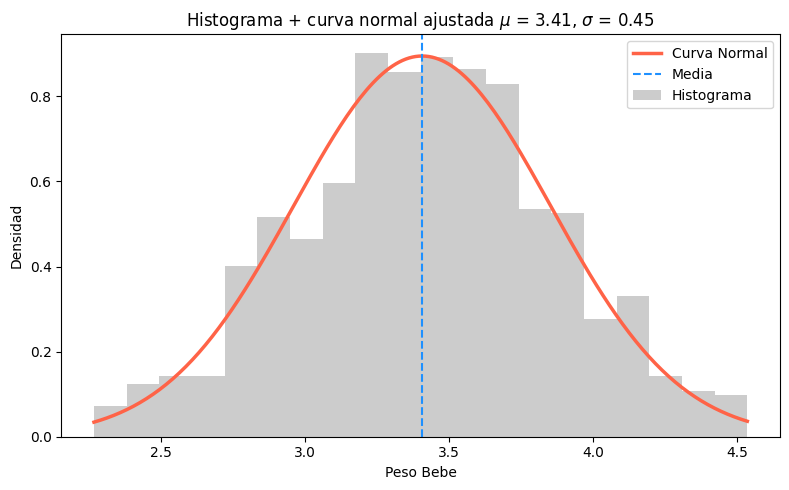

In [12]:
plt.figure(figsize=(8, 5))

# Histograma en densidad (no frecuencias absolutas)
sns.histplot(data,
             bins='fd',
             stat="density",   # normaliza a densidades para comparar con curva normal
             color="grey",
             alpha=.4,
             edgecolor="none")

# Curva normal teórica
plt.plot(x, y, color='tomato', linewidth=2.5)

# línea vertical con la media
plt.axvline(mu, color='dodgerblue',linestyle="--", linewidth=1.5)

plt.xlabel("Peso Bebe")
plt.ylabel("Densidad")
plt.title(r"Histograma + curva normal ajustada $\mu$ = {:.2f}, $\sigma$ = {:.2f}".format(mu, sigma))
plt.legend(["Curva Normal", "Media", 'Histograma'])
plt.tight_layout()
plt.show()

Como se puede observar los datos distribuyen como normal por la similitud del histograma y la curva de la normal con los parámetros obtenidos de los datos.

### 3. Probar modelo normal
Considerando lo anterior, verifica el modelo de distribución normal de los pesos para 5 valores diferentes. Compara con los datos reales.

---

A continuación, se probara el modelo con 5 valores obtenidos de forma aleatoria desde los datos y luego comparados con el modelo:

Valores Reales:  [2.4664065, 3.572037, 3.4869885, 3.288542, 3.5436875]
Valores Modelo:  [2.99438409 3.52613782 3.05638597 2.93873656 3.75509469]
Error cuadrático medio (MSE):  0.12666849233698935


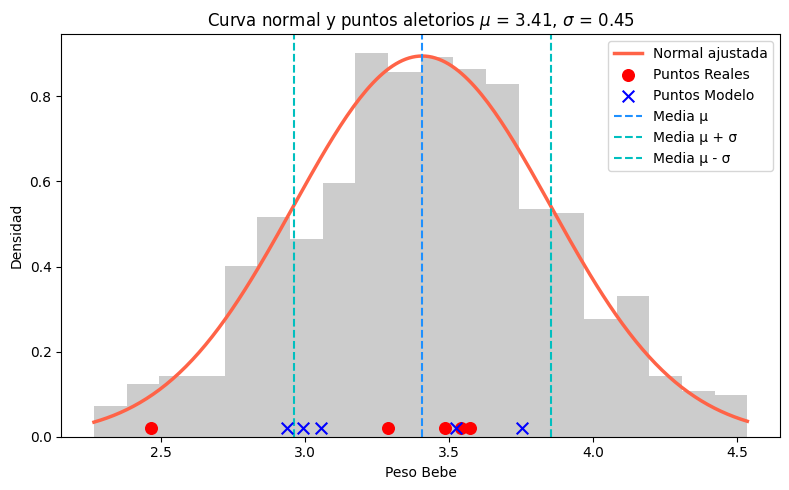

In [13]:
import random

random.seed(137)

random_valores_reales = random.sample(list(df['Birth.Weight']), 5)
random_valores_modelo = np.random.normal(mu, sigma, 5)

print("Valores Reales: ", random_valores_reales)
print("Valores Modelo: ", random_valores_modelo)
MSE = np.mean((random_valores_reales - random_valores_modelo) ** 2)
print("Error cuadrático medio (MSE): ", MSE)

plt.figure(figsize=(8, 5))

# Curva normal teórica
plt.plot(x, y, color='tomato', linewidth=2.5, label="Normal ajustada")

# línea vertical con la media
plt.scatter(random_valores_reales, np.zeros_like(random_valores_reales) + 0.02,
            marker="o", s=70, color="r", zorder=5, label="Puntos Reales")

plt.scatter(random_valores_modelo, np.zeros_like(random_valores_modelo) + 0.02,
            marker="x", s=70, color="b", zorder=5, label="Puntos Modelo")

plt.axvline(mu, color='dodgerblue', linestyle="--", linewidth=1.5, label="Media μ")
plt.axvline(mu + sigma, color='c', linestyle="--", linewidth=1.5, label="Media μ + σ")
plt.axvline(mu - sigma, color='c', linestyle="--", linewidth=1.5, label="Media μ - σ")

sns.histplot(data,
             bins='fd',
             stat="density",
             color="grey",
             alpha=.4,
             edgecolor="none")

plt.xlabel("Peso Bebe")
plt.ylabel("Densidad")
plt.title(r"Curva normal y puntos aletorios $\mu$ = {:.2f}, $\sigma$ = {:.2f}".format(mu, sigma))
plt.legend()
plt.tight_layout()
plt.show()

Tanto los puntos reales como los del modelo en su mayoria caen entre [μ - σ, μ + σ]. Además, el error cuadrático medio (MSE, sirve para comparar errores entre modelos y observaciones) entre los valores es muy pequeño. Esto es un indicio de que el modelo normal apróxima el comportamiento de estos datos.

### 4. Comparación pesos bebes
Compara los pesos de los bebés de madres fumadoras y no fumadoras. ¿Qué diferencias existen? Explica y construye los modelos correspondientes.

---

Para poder comparar los pesos de los bebes de ambos grupos (madres fumadoras y no fumadoras) se calcularan los parámetros de ambos grupos y luego se graficará:

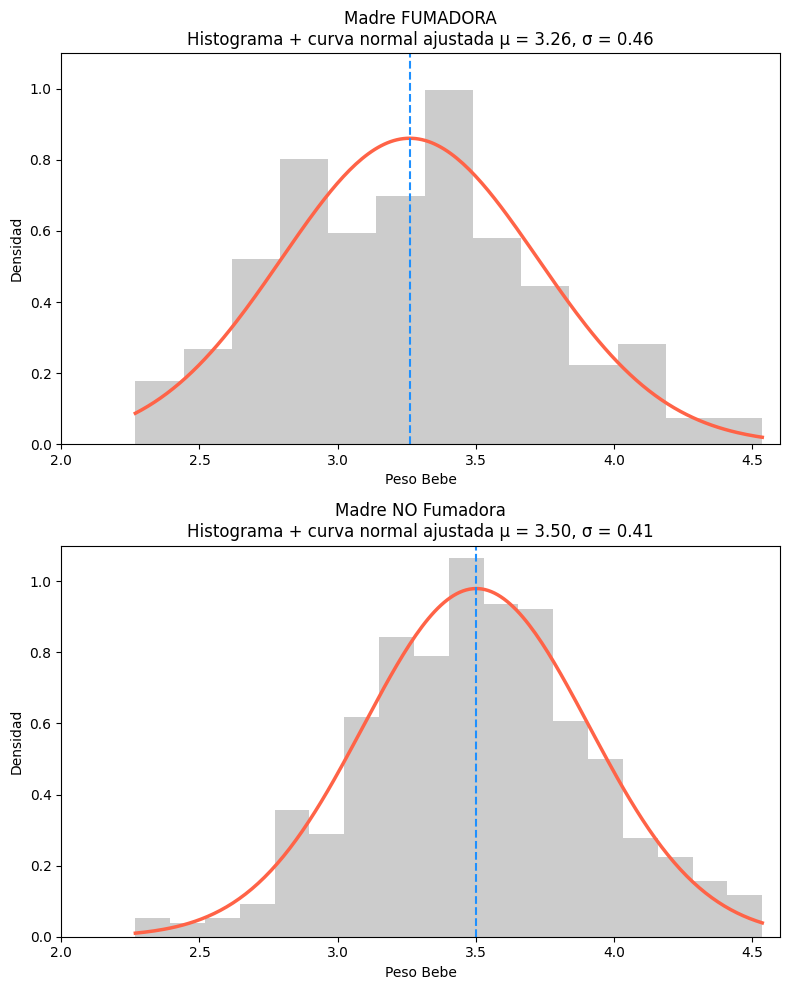

In [20]:
df_pesos_fumador = df[df['Maternal.Smoker'] == True]['Birth.Weight']
df_pesos_no_fumador = df[df['Maternal.Smoker'] == False]['Birth.Weight']

mu_fumador, sigma_fumador = df_pesos_fumador.mean(), df_pesos_fumador.std(ddof=0)
mu_no_fumador, sigma_no_fumador = df_pesos_no_fumador.mean(), df_pesos_no_fumador.std(ddof=0)

data = df['Birth.Weight']
x = np.linspace(data.min(), data.max(), 200)

y_fumador = normal(x, mu_fumador, sigma_fumador)
y_no_fumador = normal(x, mu_no_fumador, sigma_no_fumador)


fig, axes = plt.subplots(2, 1,
                         figsize=(8, 2 * 5),
                         sharex=False, sharey=False)

axes = axes.ravel()

# Gráfico Fumador
ax = axes[0]
sns.histplot(df_pesos_fumador,
             bins='fd',
             stat="density",
             color="grey",
             alpha=.4,
             edgecolor="none",
             ax=ax)

ax.plot(x, y_fumador, color='tomato', linewidth=2.5)
ax.axvline(mu_fumador, color='dodgerblue',linestyle="--", linewidth=1.5)

ax.set_title("Madre FUMADORA\nHistograma + curva normal ajustada μ = {:.2f}, σ = {:.2f}".format(mu_fumador, sigma_fumador))
ax.set_xlabel("Peso Bebe")
ax.set_ylabel("Densidad")
ax.set_xlim(2, 4.6)
ax.set_ylim(0, 1.1)

# Gráfico NO Fumador
ax = axes[1]
sns.histplot(df_pesos_no_fumador,
             bins='fd',
             stat="density",
             color="grey",
             alpha=.4,
             edgecolor="none",
             ax=ax)

ax.plot(x, y_no_fumador, color='tomato', linewidth=2.5)
ax.axvline(mu_no_fumador, color='dodgerblue',linestyle="--", linewidth=1.5)

ax.set_title("Madre NO Fumadora\nHistograma + curva normal ajustada μ = {:.2f}, σ = {:.2f}".format(mu_no_fumador, sigma_no_fumador))
ax.set_xlabel("Peso Bebe")
ax.set_ylabel("Densidad")
ax.set_xlim(2, 4.6)
ax.set_ylim(0, 1.1)


plt.tight_layout()
plt.show()

Como se ve en el gráfico y los datos estadísticos, en promedio los bebes de madres fumadoras tienen un peso menor (μ = 3.26Kg) al de las madres no fumadoras (μ = 3.50Kg). La diferencia en promedio es de 0.24Kg.

### 5. Considerando los datos dados:

Calcular:
- Calcula la probabilidad de que una madre escogida al azar fume.
- A partir del valor anterior, construye un modelo de distribución binomial que
modele el experimento correspondiente a escoger 5 madres al azar y observar
cuántas fuman.
- Utilizando este modelo, simula 1000 muestras de tamaño 8, y calcula sus medias
muestrales.
- Utilizando los datos directamente, extrae 1000 muestras de tamaño 8 y calcula sus respectivas medias muestrales.

Utilizando lo anterior:

- Compara gráficamente los resultados obtenidos anteriormente.
- Verifica el teorema del límite central, considerando las muestras de datos reales y
las simuladas con el modelo binomial.
- Construye un modelo de distribución normal derivado del modelo binomial, y
grafícalo junto a los anteriores para comparar. Concluye.

---

Primero Calcular probabilidad de que una madre sea escogida al azar fume

In [15]:
p_fuma = df[df['Maternal.Smoker'] == True].shape[0] / df.shape[0]
print("Probabilidad de que una madre sea fumadora: {:.2f}%".format(p_fuma * 100))

Probabilidad de que una madre sea fumadora: 39.03%


Se genera el experimento de escoger 5 madres al azar y observar cuantas fuman:

In [16]:
def experimento_binomial(muestra: int) -> list:
  return np.random.binomial(5, p_fuma, muestra)

Experimento simulación: Se genera la simulación y se obtiene las medias muestrales:

In [24]:
medias_muestral_simulacion = list()
for i in range(1000):
  experimento = experimento_binomial(muestra=8)
  medias_muestral_simulacion.append(np.mean(experimento))


Experimento datos reales: Se obtiene las medias muestrales directamente desde los datos:

In [25]:
medias_muestral_real = list()
for i in range(1000):
  experimento = list()
  for j in range(8):
    experimento.append(int(np.sum(random.sample(list(df['Maternal.Smoker']), 5))))
  medias_muestral_real.append(np.mean(experimento))

Para generar las PDF de ambos experimentos se calculan los parámetros de la normal para ambas muestras:

In [26]:
x = np.linspace(min(min(medias_muestral_real), min(medias_muestral_simulacion)),
                max(max(medias_muestral_real), max(medias_muestral_simulacion)), 200)

mu_simu = np.mean(medias_muestral_simulacion)
sigma_simu = np.std(medias_muestral_simulacion, ddof=0)

mu_real = np.mean(medias_muestral_real)
sigma_real = np.std(medias_muestral_real, ddof=0)

y_simu = normal(x, mu_simu, sigma_simu)
y_real = normal(x, mu_real, sigma_real)

Se procede a gráficar el histograma y la PDF normal en ambos casos para comparar:

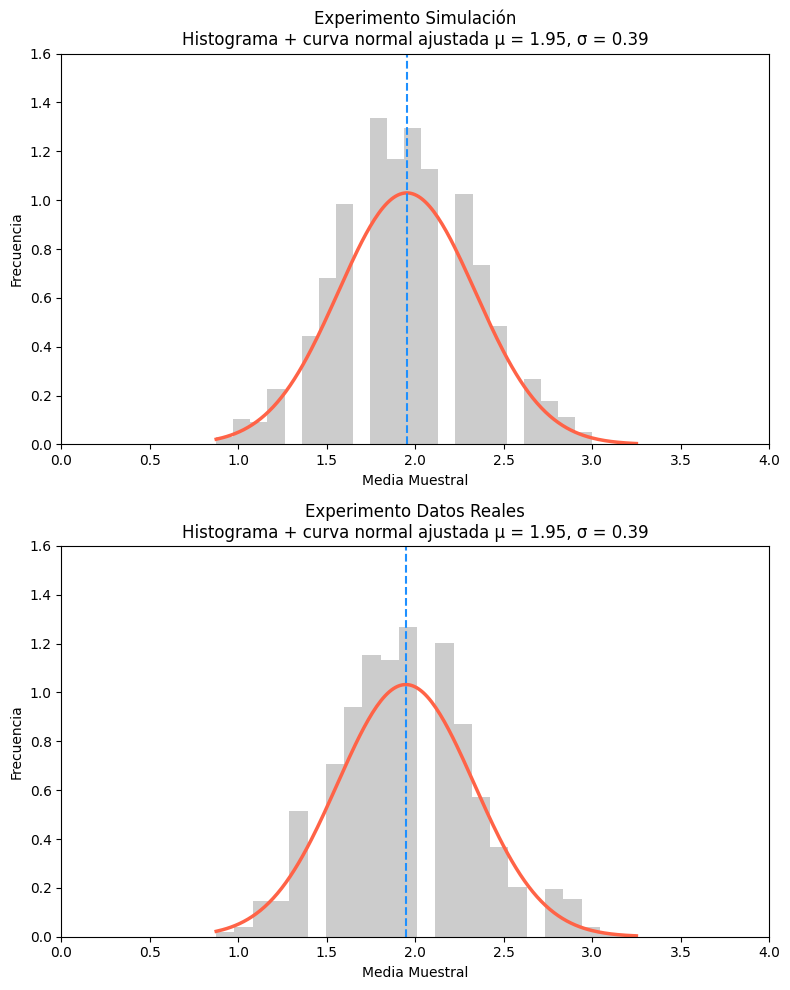

In [27]:
fig, axes = plt.subplots(2, 1,
                         figsize=(8, 2 * 5),
                         sharex=False, sharey=False)

axes = axes.ravel()

# Histograma
ax = axes[0]
sns.histplot(medias_muestral_simulacion,
             bins='fd',
             color="grey",
             stat="density",
             alpha=.4,
             edgecolor="none",
             ax=ax)

ax.plot(x, y_simu, color='tomato', linewidth=2.5)
ax.axvline(mu_simu, color='dodgerblue',linestyle="--", linewidth=1.5)

ax.set_title("Experimento Simulación\nHistograma + curva normal ajustada μ = {:.2f}, σ = {:.2f}".format(mu_simu, sigma_simu))
ax.set_xlabel("Media Muestral")
ax.set_ylabel("Frecuencia")
ax.set_xlim(0, 4)
ax.set_ylim(0, 1.6)

ax = axes[1]
sns.histplot(medias_muestral_real,
             bins='fd',
             color="grey",
             stat="density",
             alpha=.4,
             edgecolor="none",
             ax=ax)

ax.plot(x, y_real, color='tomato', linewidth=2.5)
ax.axvline(mu_real, color='dodgerblue',linestyle="--", linewidth=1.5)

ax.set_title("Experimento Datos Reales\nHistograma + curva normal ajustada μ = {:.2f}, σ = {:.2f}".format(mu_real, sigma_real))
ax.set_xlabel("Media Muestral")
ax.set_ylabel("Frecuencia")
ax.set_xlim(0, 4)
ax.set_ylim(0, 1.6)

plt.tight_layout()
plt.show()

Aunque las muestras de los 2 experimentos son de diferente naturaleza (experimento con datos reales y otro simulando un experimento con distribución binomial) los resultados son muy parecidos. En ambos casos la media y la desviación de la media muestral son similares. Esto confirma el Teorema Central del Límite (TCL) que dice que la distribución de la media de una muestra grande de variables aleatorias independientes, independientemente de la distribución de la población original, tiende a una distribución normal.